# **AraBERT v1 & v2: Pre-training BERT for Arabic Language Understanding**

# 1.0. Download the needed libraries

In [61]:
!pip install datasets evaluate transformers[sentencepiece] seqeval --quiet

**1.1. Upload and group words**

In [62]:
import pandas as pd

df = pd.read_excel("/content/All_data.xlsx")
df = df.groupby("Sentence #").agg({"word": list, "aspect": list, "categort": list, "polarity": list}).reset_index()

/usr/local/lib/python3.11/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


**1.2. Combine the Category and Aspect Columns to create target column**

In [63]:
def combine(row):
    return [f"{asp}-{cat}" if asp != "O" else "O" for asp, cat in zip(row["aspect"], row["categort"])]

df["new_col"] = df.apply(combine, axis=1)

df

,Sentence #,word,aspect,categort,polarity,new_col
0,Sentence:0,"[عمال, شركات, التوصيل, أمثال, ذبحونا, ابعث, لي...","[O, O, O, O, B, O, O, B, O, O, O, O, O, O, O, ...","[O, O, O, O, Service, O, O, Location, O, O, O,...","[O, O, O, O, Neg, O, O, Neg, O, O, O, O, O, O,...","[O, O, O, O, B-Service, O, O, B-Location, O, O..."
1,Sentence:1,"[أسو, خدمة, مرت, علي, بحياتي, و, فوق, هذا, اكل...","[B, I, O, O, O, O, O, O, O, O, B, O, O, O, O, ...","[Service, Service, O, O, O, O, O, O, O, O, Ser...","[Neg, Neg, O, O, O, O, O, O, O, O, Neg, O, O, ...","[B-Service, I-Service, O, O, O, O, O, O, O, O,..."
2,Sentence:10,"[متخيلة, يقول, ليي, روحي, للبيت, اخذي, اوردرش,...","[O, O, O, O, O, O, B, O, O, O, O, B, I, O, O, ...","[O, O, O, O, O, O, Service, O, O, O, O, Locati...","[O, O, O, O, O, O, Neg, O, O, O, O, Neg, Neg, ...","[O, O, O, O, O, O, B-Service, O, O, O, O, B-Lo..."
3,Sentence:100,"[ليش, بتطلبوا, العنوان, عالموقع, اذا, السائق, ...","[O, O, I, B, O, O, O, O, O, O, I, O, O, I, I, ...","[O, O, Location, Location, O, O, O, O, O, O, L...","[O, O, Neg, Neg, O, O, O, O, O, O, Neg, O, O, ...","[O, O, I-Location, B-Location, O, O, O, O, O, ..."
4,Sentence:1000,"[كلمهم, بالانستغرام, بنص, ساعة, لك, فلوسك, يردون]","[O, O, O, I, O, B, B]","[O, O, O, Time, O, Price, Price]","[O, O, O, Neg, O, Pos, Pos]","[O, O, O, I-Time, O, B-Price, B-Price]"
...,...,...,...,...,...,...
4841,Sentence:995,"[تطبيق, منتجاتنا, على, طلبات, في, مدينة, العين...","[B, O, O, O, O, O, O, O, O, O, I, O, O, O, O, ...","[Service, O, O, O, O, O, O, O, O, O, Time, O, ...","[Pos, O, O, O, O, O, O, O, O, O, Neg, O, O, O,...","[B-Service, O, O, O, O, O, O, O, O, O, I-Time,..."
4842,Sentence:996,"[ابشرك, انا, طالب, من, ساعه, والغو, الطلب, وسح...","[O, O, B, O, I, O, O, B, I, O, O, O, O, O, I, ...","[O, O, Time, O, Time, O, O, Price, Price, O, O...","[O, O, Neg, O, Neg, O, O, Neg, Neg, O, O, O, O...","[O, O, B-Time, O, I-Time, O, O, B-Price, I-Pri..."
4843,Sentence:997,"[اسوا, خدمه, فعلا, من, امس, طلبت, وتم, الغا, ا...","[B, I, O, O, O, O, O, B, O, O, I, O, O, B, I, ...","[Service, Service, O, O, O, O, O, Service, O, ...","[Neg, Neg, O, O, O, O, O, Neg, O, O, Neg, O, O...","[B-Service, I-Service, O, O, O, O, O, B-Servic..."
4844,Sentence:998,"[اني, اللي, قهرني, البارحه, انه, يطلع, ليي, دق...","[O, O, O, O, O, O, O, O, O, O, O, O, I, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, Time, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, Neg, O, O...","[O, O, O, O, O, O, O, O, O, O, O, O, I-Time, O..."


**1.3. Align word labels with tokenized inputs (Handling subwords and special tokens)**

In [65]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            current_word = word_id
            label = -100 if word_id is None else label_to_id[labels[word_id]]
            new_labels.append(label)
        elif word_id is None:
            new_labels.append(-100)
        else:
            label = label_to_id[labels[word_id]]
            new_labels.append(label)
    return new_labels

**1.4. Tokenize and Prepare Labels for Token Classification**

In [66]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True,padding="max_length", is_split_into_words=True
    )
    all_labels = examples["labels"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs


**1.5. Split the data and create train and test datasets**

In [ ]:
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["word"].tolist(), df["new_col"].tolist(), test_size=0.1, random_state=42
)

train_dataset = Dataset.from_dict({
    "tokens": train_texts,
    "labels": train_labels
})

test_dataset = Dataset.from_dict({
    "tokens": test_texts,
    "labels": test_labels
})


**1.6. Combine into a DatasetDict**

In [67]:
datasets = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

# 2.0. Extract unique labels and create Label-to-ID and ID-to-Label mappings

In [68]:
label_list = set(label for row in df['new_col'] for label in row)

label_to_id = dict({label: idx for idx, label in enumerate(label_list)})
id_to_label = dict({idx: label for label, idx in label_to_id.items()})

**2.1. Tokenize and align labels**

In [69]:
tokenized_datasets = datasets.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=datasets["train"].column_names,
)

Map:   0%|          | 0/4361 [00:00<?, ? examples/s]

Map:   0%|          | 0/485 [00:00<?, ? examples/s]

**2.2. Load Pre-trained AraBERTv2 Model**

In [70]:
from transformers import AutoModelForTokenClassification

model_checkpoint = "aubmindlab/bert-base-arabertv2"
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(label_list),
    id2label=id_to_label,
    label2id=label_to_id,
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**2.3. Define a metric function to compute loss**

In [71]:
import evaluate

# Load evaluation metric
metric = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = predictions.argmax(axis=-1)

    true_predictions = [
        [id_to_label[pred] for (pred, label) in zip(prediction, label) if label != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id_to_label[label] for (pred, label) in zip(prediction, label) if label != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }


**2.4. Define training arguments**

In [72]:
from transformers import TrainingArguments

# Define training arguments
args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to="none"
    #push_to_hub=True,
)

**2.5. Define trainer to train the model**

In [73]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

<ipython-input-73-ccad9dea9dbc>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


# **3.0. Train the model**

In [74]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.712500,0.472440,0.611084,0.514663,0.558744,0.859663
2,0.462600,0.437655,0.625118,0.544816,0.582211,0.868361
3,0.403400,0.432967,0.617501,0.565469,0.590341,0.868423


TrainOutput(global_step=1638, training_loss=0.5154023479047131, metrics={'train_runtime': 1318.6742, 'train_samples_per_second': 9.921, 'train_steps_per_second': 1.242, 'total_flos': 3418792723261440.0, 'train_loss': 0.5154023479047131, 'epoch': 3.0})

# ***In case the training progress wasn't displayed on VS code here's screenshot***

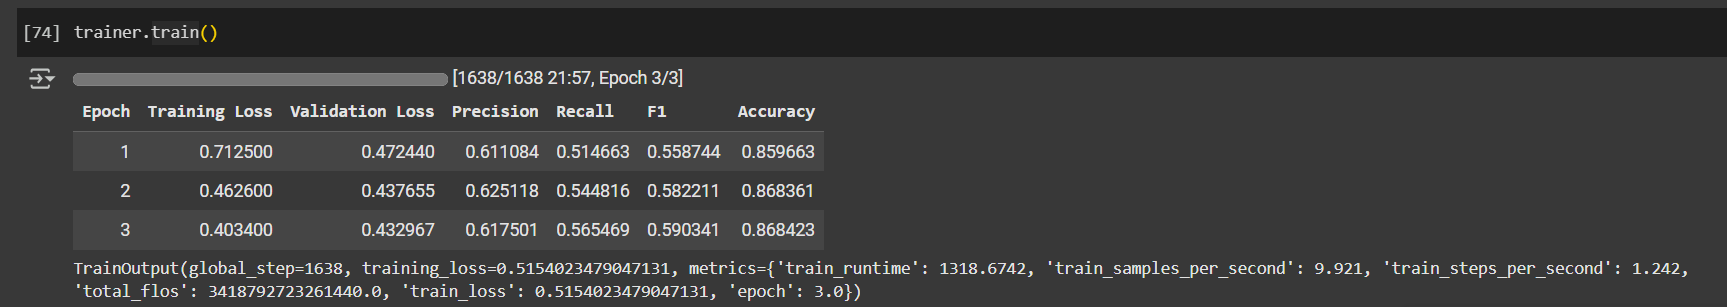